In [1]:
# The program is set up to generate N neurons for the GPT-PINN. Once N neurons 
# has been achieved it is further trained to examine the largest loss 
# over all parameters once more. This is not needed for practical use.
# Set "train_final = False" (Line 60), if you wish to remove this behavior.

# Third-party and Standard Libraries
from datetime import datetime
import numpy as np
import torch
import time
import os
import matplotlib.pyplot as plt
print(f"Program Start: {datetime.now()}\n")

# Modules
from B_test import gpt_test, gpt_test_loss, pinn_test, pinn_test_loss
from B_data import residual_data, ICBC_data
from B_train import offline_generation,offline_generation_GD,offline_generation_lbfgs_gpt
from B_train import pinn_train
from B_precomp import gram_schmidt1, inputs,gram_schmidt2_zero
from B_models import NN

data_dir = "./b_data/"
if (os.path.exists(data_dir) == False):
    os.makedirs(data_dir)

#torch.manual_seed(1234)
#np.random.seed(1234)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print_seperator = 60*"*"

sparse = False

if (sparse):
    ext = "s"
else:
    ext = ""

###############################################################################
#### Domain and Simulated Data ####
Xi, Xf         = -1.0, 1.0
Ti, Tf         =  0.0, 1.0
Nc, N_test     =  100, 100
BC_pts, IC_pts =  200, 200

xt_resid, f_hat, xt_test = residual_data(Xi, Xf, Ti, Tf, Nc, N_test)
xt_resid = xt_resid.to(device)
f_hat    = f_hat.to(device)
xt_test  = xt_test.to(device) 

IC_xt, IC_u, BC_xt, BC_u = ICBC_data(Xi, Xf, Ti, Tf, BC_pts, IC_pts) 
IC_xt = IC_xt.to(device)
IC_u  = IC_u.to(device)
BC_xt = BC_xt.to(device)
BC_u  = BC_u.to(device) 

#### Training Parameter Set ####
b_train = np.linspace(0.005, 1, 129)

#### PINN Attributes ####
layers_pinn = np.array([2, 20, 20, 20, 20, 1])
lr_pinn     = 0.005
epochs_pinn = 60000
tol         = 2e-5

#### GPT-PINN Attributes ####
train_final       = True
number_of_neurons = 10
lr_gpt            = 0.1
epochs_gpt_train  = 50
neurons           = np.zeros(number_of_neurons)
neurons[0]        = np.median(b_train)
#neurons[0]        = b_train[np.random.randint(low=0, high=len(b_train))]

#### GPT-PINN Test Attributes ####
test_cases      = 25
epochs_gpt_test = 50

c_init = np.zeros(number_of_neurons, dtype=object)
for i in range(number_of_neurons):
    c_init[i] = torch.full((1,i+1), 1/(i+1)).to(device)

#### Data sizes ####
test_size = xt_test.shape[0]
xt_size   = xt_resid.shape[0]
IC_size   = IC_xt.shape[0]
BC_size   = BC_xt.shape[0]

if (sparse):
    #### Training point data ####
    X_train_all   = torch.zeros((2*number_of_neurons-1,2)).to(device)
    X_all_idx     = torch.zeros( 2*number_of_neurons-1, dtype=torch.long).to(device)
    X_umax_idx    = torch.zeros(   number_of_neurons,   dtype=torch.long).to(device)
    X_rmax_idx    = torch.zeros(   number_of_neurons-1, dtype=torch.long).to(device)
    residual_full = torch.zeros((xt_size, number_of_neurons-1)).to(device)

#### Neuron outputs on the full training grid ####
xt_resid    = xt_resid.requires_grad_()
out_full    = torch.zeros((xt_size, number_of_neurons)).to(device)
out_BC      = torch.zeros((BC_size, number_of_neurons)).to(device)
out_IC      = torch.zeros((IC_size, number_of_neurons)).to(device)
out_t_full  = torch.zeros((xt_size, number_of_neurons)).to(device)
out_x_full  = torch.zeros((xt_size, number_of_neurons)).to(device)
out_xx_full = torch.zeros((xt_size, number_of_neurons)).to(device)

out_full_zero    = torch.zeros((xt_size, number_of_neurons)).to(device)
out_t_full_zero  = torch.zeros((xt_size, number_of_neurons)).to(device)
out_x_full_zero  = torch.zeros((xt_size, number_of_neurons)).to(device)
out_xx_full_zero = torch.zeros((xt_size, number_of_neurons)).to(device)

#### Neuron outputs on the test grid ####
out_test = torch.zeros((test_size, number_of_neurons)).to(device) 

num_largest_mag = int(xt_size*0.2)
idx_list        = torch.zeros((number_of_neurons, num_largest_mag),
                              dtype=torch.long)
loss_list       = np.zeros(number_of_neurons)
generation_time = np.zeros(number_of_neurons)

Program Start: 2025-01-02 07:39:45.036996



In [2]:
plot_test=True
if plot_test:
    nu_test1=0.05
    PINN1 = NN(layers_pinn, nu_test1).to(device)
    pinn_losses = pinn_train(PINN1, nu_test1, xt_resid, IC_xt, IC_u, BC_xt, BC_u, f_hat, epochs_pinn, lr_pinn, tol)
    #largest_loss, largest_case,trained_c1 = offline_generation_GD([nu_test1], xt_size, IC_size, BC_size, IC_u, BC_u, train_out, train_out_x, train_out_t, train_out_xx, train_out_IC, train_out_BC, fhat, epochs_gpt_train, lr_gpt, neurons, i,c_initial)
    #plt.imshow((abs(PINN1(xt_test).view(-1)-out_test[:,:i+1]@trained_c1)).reshape(100,100).detach().cpu().numpy())
    #plt.colorbar()
    #plt.savefig("test1.png")
    #plt.close()
    nu_test2=0.80
    PINN2 = NN(layers_pinn, nu_test2).to(device)
    pinn_losses = pinn_train(PINN2, nu_test2, xt_resid, IC_xt, IC_u, BC_xt, BC_u, f_hat, epochs_pinn, lr_pinn, tol)
    #largest_loss, largest_case,trained_c2 = offline_generation_GD([nu_test2], xt_size, IC_size, BC_size, IC_u, BC_u, train_out, train_out_x, train_out_t, train_out_xx, train_out_IC, train_out_BC, fhat, epochs_gpt_train, lr_gpt, neurons, i,c_initial)
    #plt.imshow((abs(PINN2(xt_test).view(-1)-out_test[:,:i+1]@trained_c2)).reshape(100,100).detach().cpu().numpy())
    #plt.colorbar()
    #plt.savefig("test2.png")

/dssg/home/acct-matxzl/matxzl/.local/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


PINN Final Loss: 1.995983620872721e-05
PINN Final Loss: 1.9982306184829213e-05


GPT-PINN Training Started
************************************************************
PINN Final Loss: 1.999813139264006e-05
PINN time: 2.079183880488078 minutes

Generation time: 0.08501072724660237 minutes

Largest Loss (Using 1 Neurons): 0.3443588316440582
Parameter Case: 0.03609375



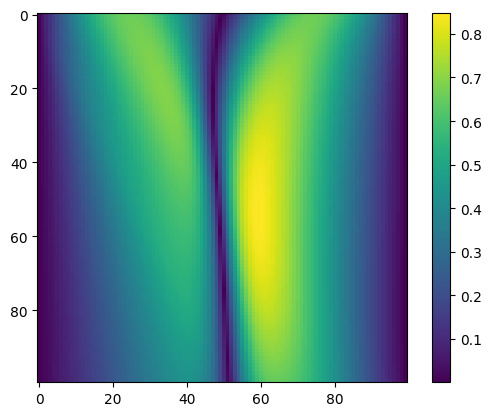

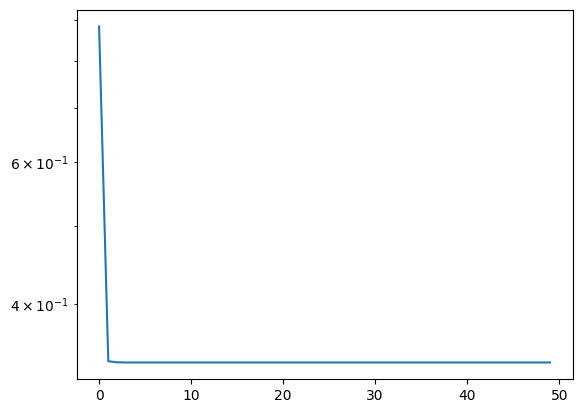

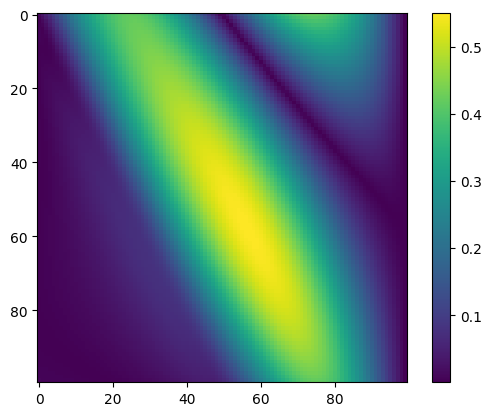

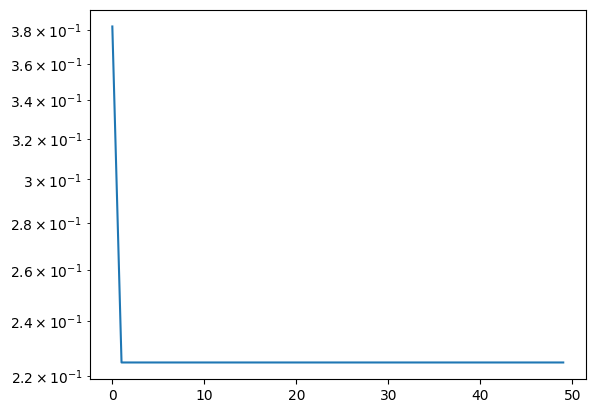

************************************************************
PINN Final Loss: 1.9800094378297217e-05
PINN time: 1.3443946957588195 minutes

Generation time: 0.8798376361529032 minutes

Largest Loss (Using 2 Neurons): 0.34050899744033813
Parameter Case: 0.9922265625



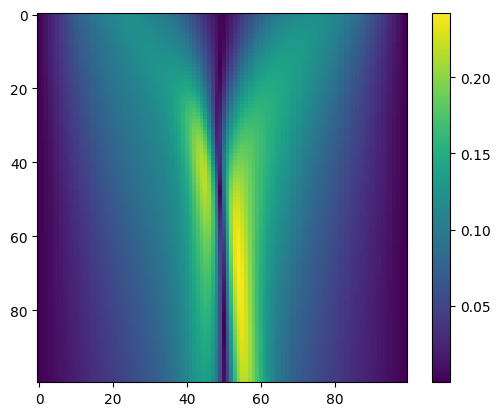

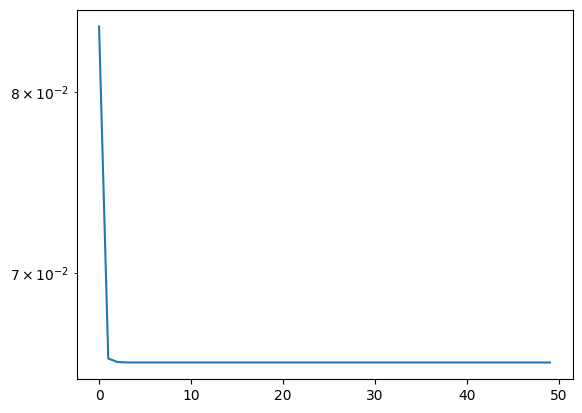

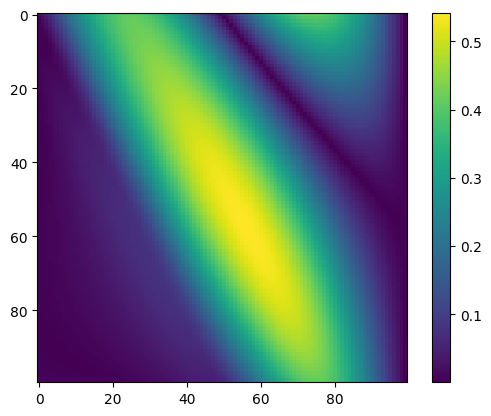

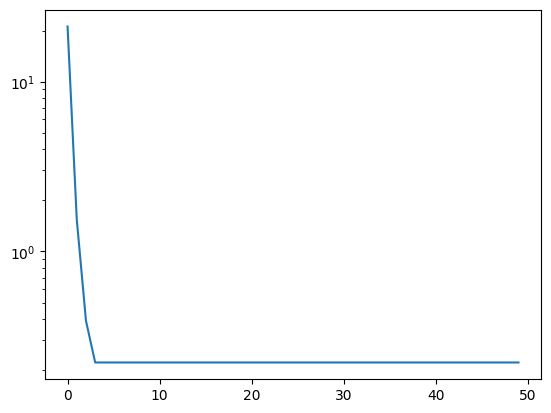

************************************************************
PINN Final Loss: 1.9997749404865317e-05
PINN time: 4.0962799469629925 minutes

Generation time: 0.21823216279347737 minutes

Largest Loss (Using 3 Neurons): 0.21090038120746613
Parameter Case: 0.0749609375



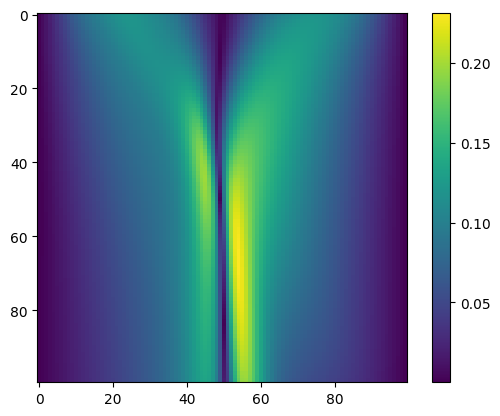

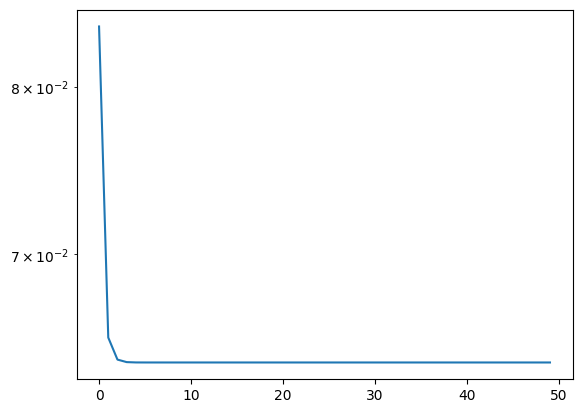

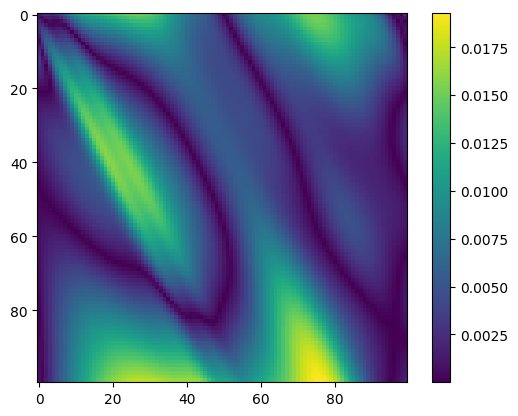

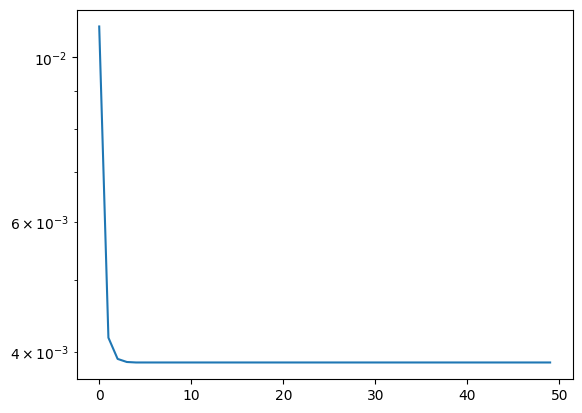

************************************************************
PINN Final Loss: 1.988770964089781e-05
PINN time: 1.2307066599527994 minutes

Generation time: 0.49867213567097984 minutes

Largest Loss (Using 4 Neurons): 0.0702706053853035
Parameter Case: 0.176015625



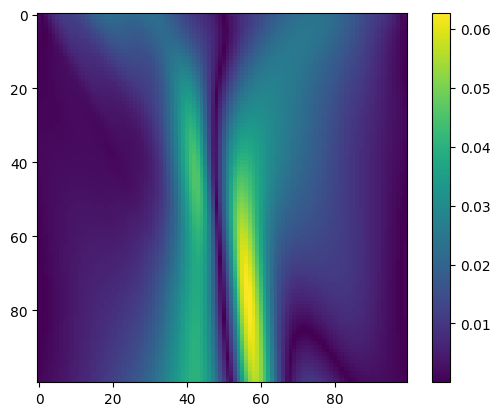

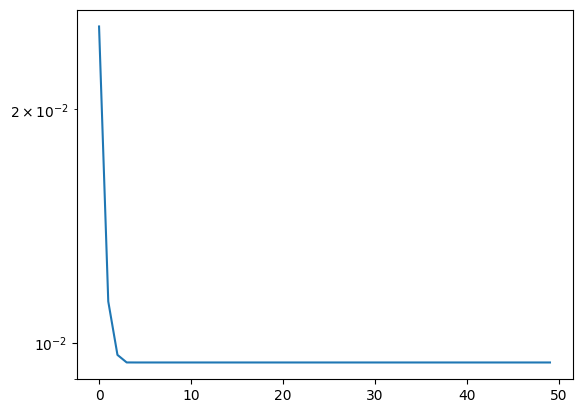

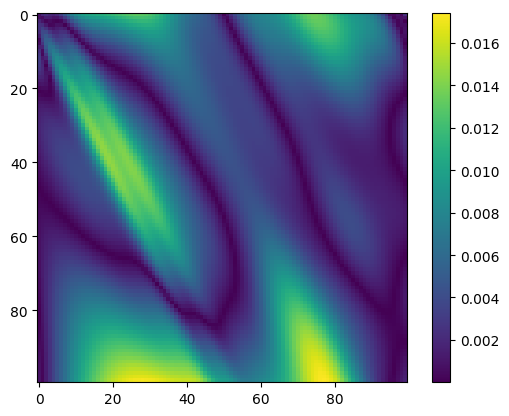

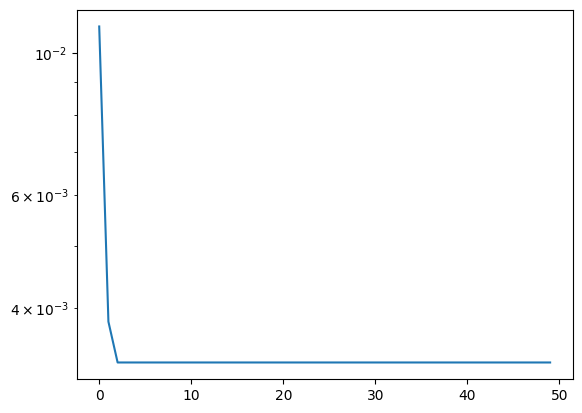

************************************************************
PINN Final Loss: 1.9849565433105454e-05
PINN time: 2.1675391952196756 minutes

Generation time: 0.3796526511510213 minutes

Largest Loss (Using 5 Neurons): 0.004529671277850866
Parameter Case: 0.051640624999999996



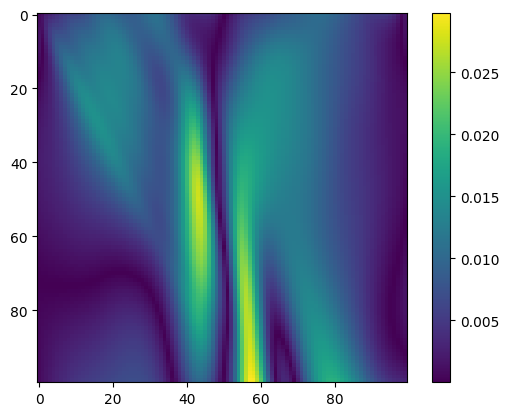

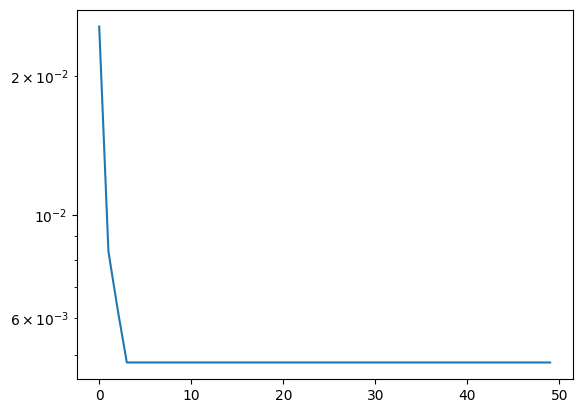

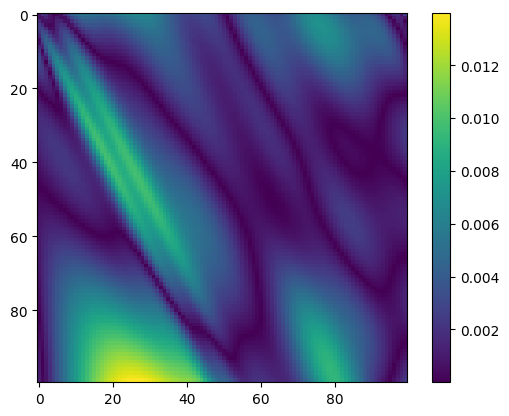

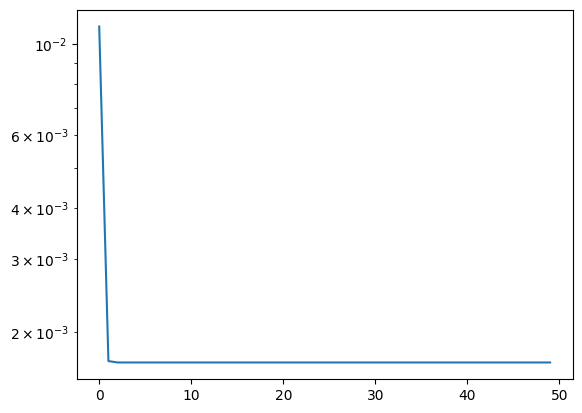

************************************************************
PINN Final Loss: 1.933873863890767e-05
PINN time: 1.7249956051508586 minutes

Generation time: 0.9490458766619364 minutes

Largest Loss (Using 6 Neurons): 0.002272921847179532
Parameter Case: 0.3081640625



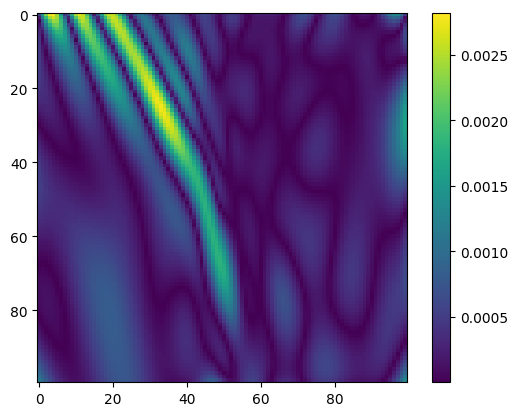

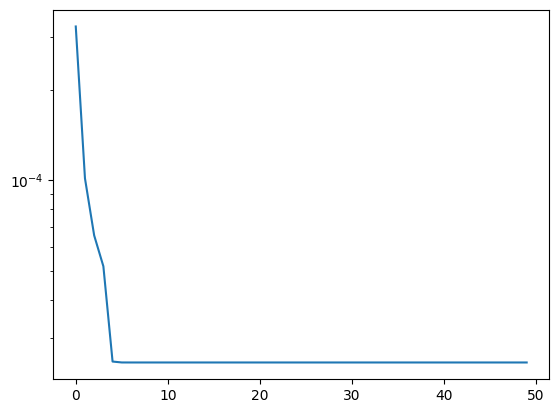

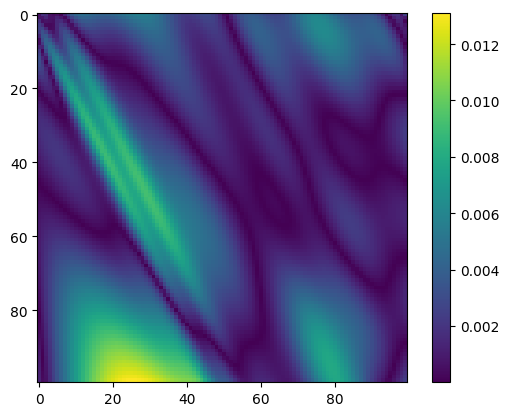

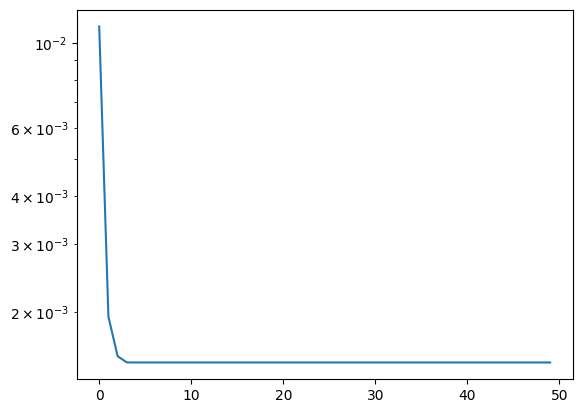

************************************************************
PINN Final Loss: 1.9997036361019127e-05
PINN time: 2.3979800303777057 minutes

Generation time: 1.410184907913208 minutes

Largest Loss (Using 7 Neurons): 0.0003988911921624094
Parameter Case: 0.7745703125



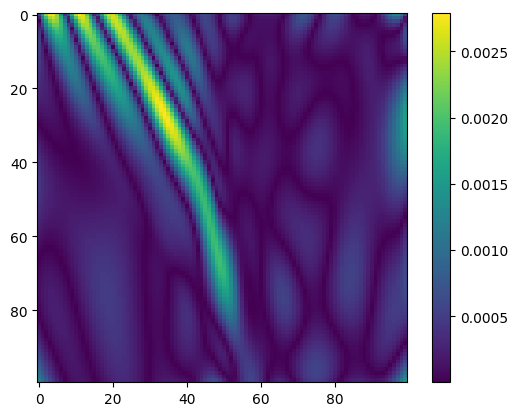

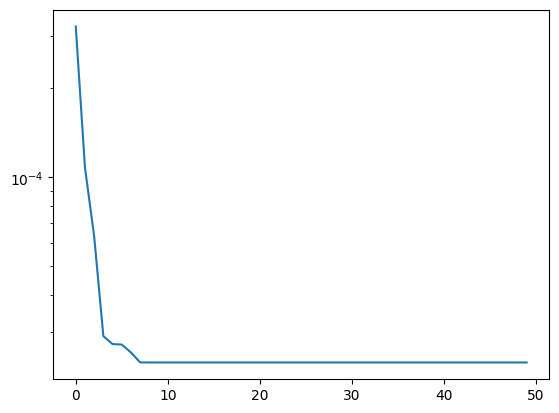

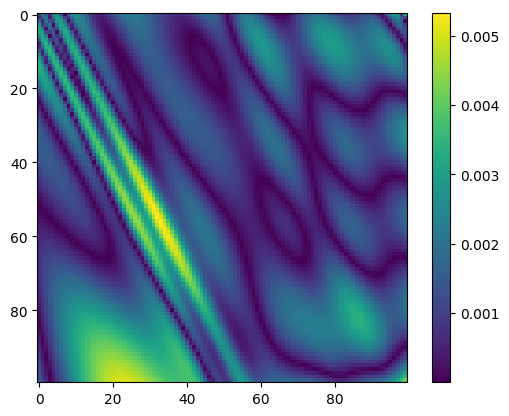

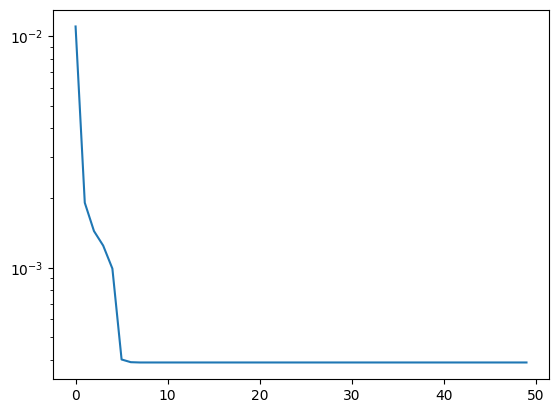

************************************************************
PINN Final Loss: 1.9976238036178984e-05
PINN time: 2.563013668855031 minutes

Generation time: 1.0232919613520304 minutes

Largest Loss (Using 8 Neurons): 0.00019956522737629712
Parameter Case: 0.113828125



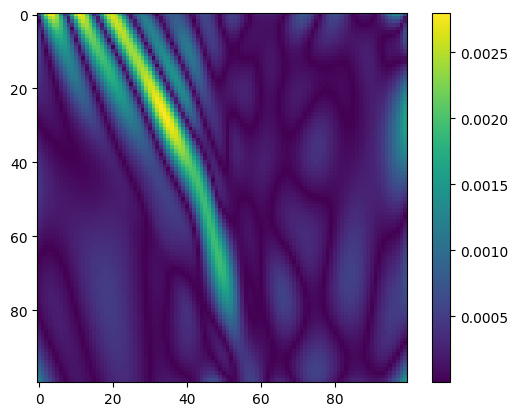

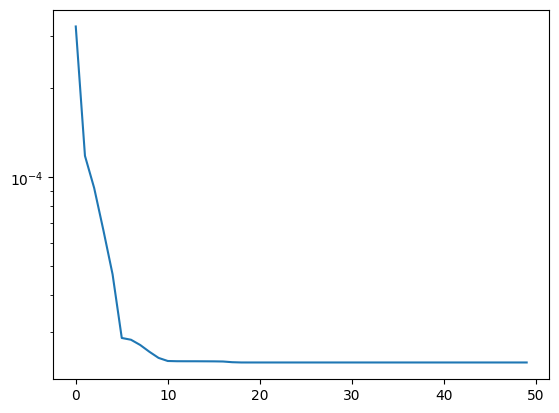

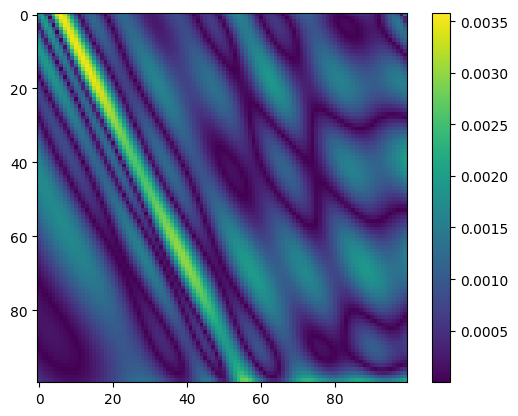

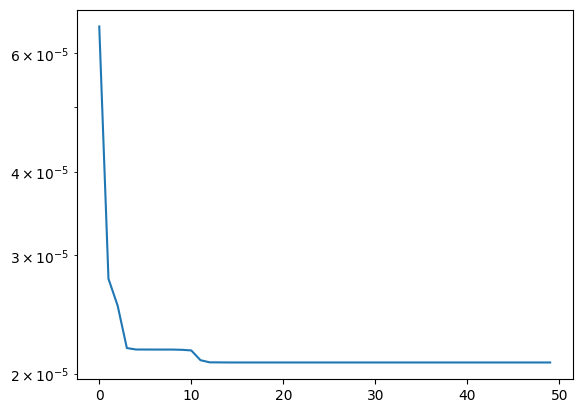

************************************************************
PINN Final Loss: 1.9830938981613144e-05
PINN time: 1.293601139386495 minutes

Generation time: 1.9971126317977905 minutes

Largest Loss (Using 9 Neurons): 4.2949362978106365e-05
Parameter Case: 0.043867187499999995



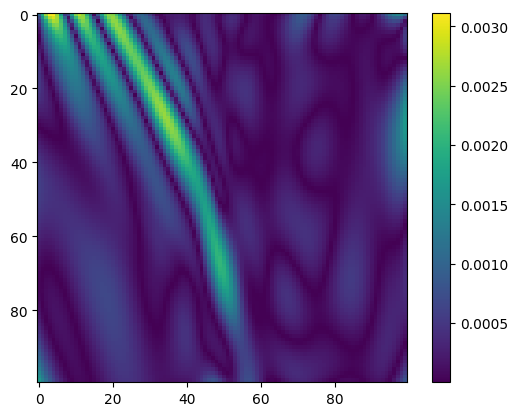

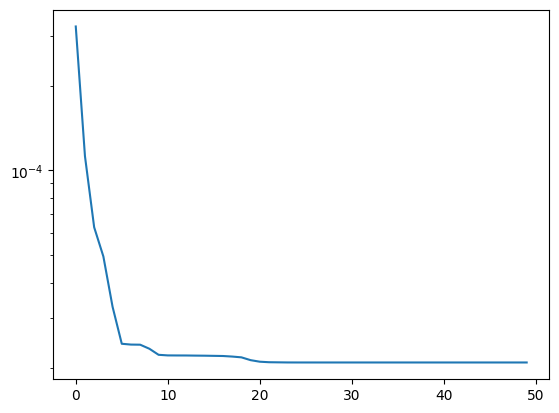

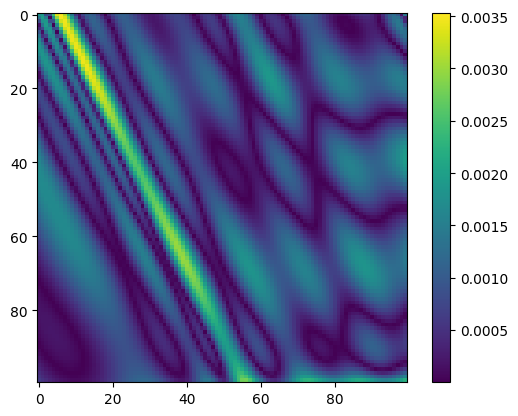

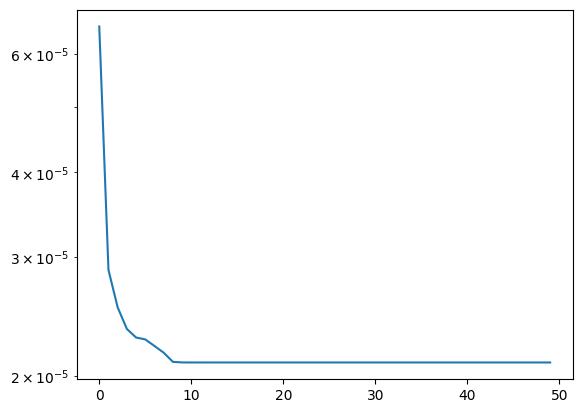

************************************************************
PINN Final Loss: 1.9962111764471047e-05
PINN time: 1.1291480859120686 minutes

Generation time: 4.199027880032857 minutes

Largest Loss (Using 10 Neurons): 5.4839063523104414e-05
Parameter Case: 0.797890625

************************************************************
GPT-PINN Training Ended

Total training time: 0.5393532654311922 Hours

Activation function parameters: 
[0.5025     0.03609375 0.99222656 0.07496094 0.17601563 0.05164062
 0.30816406 0.77457031 0.11382813 0.04386719]

Largest loss list: 
[3.44358832e-01 3.40508997e-01 2.10900381e-01 7.02706054e-02
 4.52967128e-03 2.27292185e-03 3.98891192e-04 1.99565227e-04
 4.29493630e-05 5.48390635e-05]



In [6]:
print("GPT-PINN Training Started")
total_time_1 = time.time()
for i, neuron in enumerate(neurons):
    print(print_seperator)
    # No need to train over parameters already used as neurons
    b_train = np.delete(b_train, np.where(b_train == neuron)[0])
    
    ###########################################################################
    # Full PINN to be used as activation function
    nu = neuron
    
    t1 = time.time()
    PINN = NN(layers_pinn, nu).to(device)
    pinn_losses = pinn_train(PINN, nu, xt_resid, IC_xt, IC_u, BC_xt, BC_u, 
                             f_hat, epochs_pinn, lr_pinn, tol)
    t2 = time.time()
    print(f"PINN time: {(t2-t1)/60} minutes\n")
    ###########################################################################    
    # (S)GPT-PINN Training / Offline Generation
    c_initial  = c_init[i][0]

    if (sparse):
        train_out, train_out_x, train_out_t, train_out_xx, train_out_IC, \
        train_out_BC,fhat,xt_len,ALPHA = gram_schmidt1(PINN,i, xt_resid, out_full, out_t_full, out_x_full, out_xx_full, 
                                                 out_full_zero, out_t_full_zero, out_x_full_zero, out_xx_full_zero,
                                                 out_IC, out_BC, IC_xt, BC_xt,
                                                xt_test,out_test, f_hat, X_umax_idx, X_all_idx, X_train_all,
                                                xt_size, num_largest_mag, idx_list)
        '''
        if i==0:
            c_ui = PINN(xt_resid)
            c_x_umax_idx = torch.argmax(torch.abs(c_ui))
            if c_ui[c_x_umax_idx]<0:
                c_initial[i] = -1.0
        else:
            c_initial[:i] = ALPHA.squeeze()
            c_initial[i] = 0.0
        '''
    else:
        train_out, train_out_x, train_out_t, train_out_xx, train_out_IC, \
        train_out_BC,fhat,xt_size = inputs(PINN, i, xt_resid, out_full, out_t_full, out_x_full, 
                          out_xx_full, out_IC, out_BC, IC_xt, BC_xt,  
                          out_test, xt_test,f_hat, xt_size, 
                          num_largest_mag, idx_list)

    if (train_final == False) and (i+1 == number_of_neurons):
        end = number_of_neurons-1
        break
    
    t1 = time.time()
    largest_loss, largest_case,trained_c,_ = offline_generation_lbfgs_gpt(b_train, xt_size, IC_size, 
    BC_size, IC_u, BC_u, train_out, train_out_x, train_out_t, train_out_xx, 
    train_out_IC, train_out_BC, fhat, epochs_gpt_train, lr_gpt, neurons, i)
    t2 = time.time()
    generation_time[i] = (t2-t1)/60
    print(f"Generation time: {(t2-t1)/60} minutes") 
    ###########################################################################
    loss_list[i] = largest_loss
    
    if (i+1 < number_of_neurons):
        neurons[i+1] = largest_case

    print(f"\nLargest Loss (Using {i+1} Neurons): {largest_loss}")
    print(f"Parameter Case: {largest_case}\n")
        
    if (i+1 == number_of_neurons):
        end = number_of_neurons
        break
    ###########################################################################
    if (sparse):
        nu = largest_case
        gram_schmidt2_zero(i, xt_resid,nu, trained_c, residual_full, 
                      out_full,out_t_full,out_x_full, out_xx_full, X_rmax_idx, 
                      X_all_idx, X_train_all)

    if plot_test:
        largest_loss, largest_case,trained_c1,losses1 = offline_generation_lbfgs_gpt([nu_test1], xt_size, IC_size, BC_size, IC_u, BC_u, train_out, train_out_x, train_out_t, train_out_xx, train_out_IC, train_out_BC, fhat, epochs_gpt_train, lr_gpt, neurons, i)
        plt.imshow((abs(PINN1(xt_test).view(-1)-out_test[:,:i+1]@trained_c1)).reshape(100,100).detach().cpu().numpy())
        plt.colorbar()
        plt.show()
        plt.plot(losses1)
        plt.yscale('log')
        plt.show()
        largest_loss, largest_case,trained_c2,losses2 = offline_generation_lbfgs_gpt([nu_test2], xt_size, IC_size, BC_size, IC_u, BC_u, train_out, train_out_x, train_out_t, train_out_xx, train_out_IC, train_out_BC, fhat, epochs_gpt_train, lr_gpt, neurons, i)
        plt.imshow((abs(PINN2(xt_test).view(-1)-out_test[:,:i+1]@trained_c2)).reshape(100,100).detach().cpu().numpy())
        plt.colorbar()
        plt.show()
        plt.plot(losses2)
        plt.yscale('log')
        plt.show()

total_time = (time.time() - total_time_1) / 3600      

print(print_seperator)
print("GPT-PINN Training Ended\n")
print(f"Total training time: {total_time} Hours\n")
print(f"Activation function parameters: \n{neurons}\n")
print(f"Largest loss list: \n{loss_list[:end]}\n")

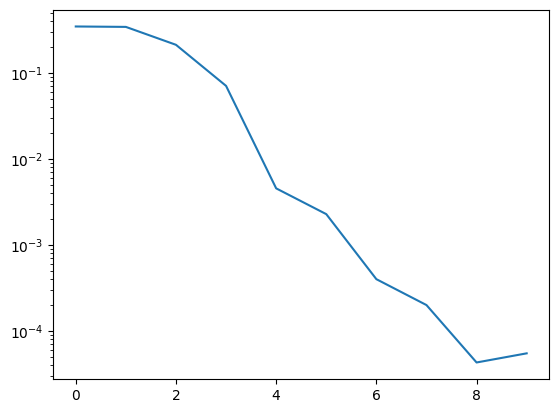

In [7]:
plt.plot(loss_list)
plt.yscale('log')
plt.show()

In [5]:
print({stop})

NameError: name 'stop' is not defined

In [8]:
#### Testing ####
# Recording losses affects the overall time so a seperate function is used
# but they can easily be combined into one.

#b_test = b_train[np.random.choice(len(b_train), test_cases, replace=False)]
b_test = np.loadtxt(data_dir + "/b_test.dat")
pinn_test_soln = np.loadtxt(data_dir+"/pinn_test_soln.dat")

from B_test_lbfgs import gpt_test_lbfgs,gpt_test_loss_lbfgs
print("GPT-PINN Testing Started")
gpt_test_time, gpt_test_soln = gpt_test_lbfgs(b_test, xt_size, IC_size, BC_size, 
IC_u, BC_u, train_out, train_out_x, train_out_t, train_out_xx, train_out_IC, 
train_out_BC, f_hat, epochs_gpt_test, lr_gpt, neurons, out_test,None,c_initial)

gpt_test_losses = gpt_test_loss_lbfgs(b_test, xt_size, IC_size, BC_size, IC_u, BC_u, 
train_out, train_out_x, train_out_t, train_out_xx, train_out_IC, train_out_BC, 
fhat, epochs_gpt_test, lr_gpt, neurons,None,c_initial)
print("GPT-PINN Testing Ended\n")

GPT-PINN Testing Started
GPT-PINN Testing Ended



In [ ]:
print({stop})

NameError: name 'stop' is not defined

In [9]:
np.savetxt(data_dir+"/gpt_generation_time.dat",  generation_time[:end])
np.savetxt(data_dir+"/gpt_max_losses.dat",       loss_list[:end])
np.savetxt(data_dir+"/gpt_neurons.dat",          neurons)
np.savetxt(data_dir+"/gpt_total_time.dat",       np.array([total_time]))
np.savetxt(data_dir+"loss_list_gpt.dat",loss_list)

np.savetxt(data_dir+"/gpt_test_losses.dat",  gpt_test_losses)
np.savetxt(data_dir+"/gpt_test_soln.dat",    gpt_test_soln)
np.savetxt(data_dir+"/gpt_test_time.dat",    gpt_test_time+total_time)

np.savetxt(data_dir+"/xt_resid.dat",         xt_resid.detach().cpu().numpy())

params = {"Device":device,
          "Domain": {"Xi": Xi, "Xf": Xf, "Ti":Ti, "Tf":Tf}, 
          "Data sizes": {"Nc":Nc, "N_test":N_test, "BC_pts":BC_pts, "IC_pts":IC_pts},
          "tol":tol,
          "layers_pinn":layers_pinn,
          "lr_pinn":lr_pinn,
          "epochs_pinn":epochs_pinn,
          "parameter size":len(b_train)+number_of_neurons,
          "number_of_neurons":number_of_neurons,
          "lr_gpt":lr_gpt,
          "epochs_gpt_train":epochs_gpt_train,
          "test_cases":test_cases,
          "epochs_gpt_test":epochs_gpt_test,
          "num_largest_mag":num_largest_mag}

np.save(data_dir+"/params_gpt.npy", params)

In [10]:
variables = {
    "b_test": b_test,
    "c_initial": c_initial,
    "xt_size": xt_size,
    "IC_size": IC_size,
    "BC_size": BC_size,
    "IC_u": IC_u,
    "BC_u": BC_u,
    "train_out": train_out,
    "train_out_x": train_out_x,
    "train_out_t": train_out_t,
    "train_out_xx": train_out_xx,
    "train_out_IC": train_out_IC,
    "train_out_BC": train_out_BC,
    "fhat": fhat,
    "epochs_gpt_test": epochs_gpt_test,
    "lr_gpt": lr_gpt,
    "neurons": neurons,
    "out_test": out_test,
}
torch.save(variables,data_dir+"/variables_gpt.npy") 